# Using a trained reflectorch model

## Loading the trained model

The first step is importing the necessary methods from the reflectorch package, as well as othar basic Python packages:

In [1]:
import torch
import matplotlib.pyplot as plt

from ipywidgets import interact
from reflectorch import get_trainer_by_name

torch.manual_seed(0); # set seed for reproducibility

In order to import a trained reflectorch model, we first have to specify the name of the trained model we wish to load. This name should match the name of the YAML configuration file used for training that model. Here we load a model for a 2-layer box parameterization of the thin film SLD profile.

In [2]:
trained_model_name = 'mc1'

Next, we initialize an instance of the `PointEstimatorTrainer` class using the `get_trainer_by_name` method.

:::{warning}
The `load_weights` argument must be set to `True` in order for the saved weights of the neural network to be loaded, otherwise the network weights are randomly initialized.
:::

In [3]:
trainer = get_trainer_by_name(config_name=trained_model_name, load_weights=True)

Model mc1 loaded. Number of parameters: 13.37 M


## Generating simulated data

We can generate a batch of simulated data using the `get_batch` method of the data loader:

In [4]:
batch_size = 64
simulated_data = trainer.loader.get_batch(batch_size=batch_size)

This method returns a dictionary with 4 entries indexed by the following keys:

 1. **params** - an instance of the `BasicParams` class containing the original (unscaled) values of the generated parameters, the generated minimum prior bound for each parameter and the generated maximum prior bound for each parameter (see the [paper](https://doi.org/10.1107/S1600576724002115) for more details about the generation process)
 2. **scaled_params** - a Pytorch Tensor containing the parameters, minimum bounds and maximum bounds, all scaled to the ML-friendly range [-1, 1]
 3. **q_values** - a Pytorch Tensor containing the reciprocal space (q) positions of the points in the reflectivity curve, in units of Å<sup>-1</sup>
 4. **scaled_noisy_curves** - a Pytorch Tensor containing the simulated reflectivity curves (including added noise) scaled to the ML-friendly range [-1, 1]

We can inspect some of the (scaled) simulated curves: 

(*interactive cursor not supported in the documentation*)

In [5]:
q = simulated_data['q_values']
scaled_noisy_curves = simulated_data['scaled_noisy_curves']
unscaled_noisy_curves = trainer.loader.curves_scaler.restore(scaled_noisy_curves)

@interact(i=(0, batch_size-1, 1))
def plot_refl_curve(i=0):
    
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlabel('q [$Å^{-1}$]', fontsize=24)
    ax.set_ylabel('R$_{scaled}$ (q)', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=15)
        
    ax.scatter(q[i].cpu().numpy(), scaled_noisy_curves[i].cpu().numpy(), c='blue', s=2.0)

interactive(children=(IntSlider(value=0, description='i', max=63), Output()), _dom_classes=('widget-interact',…

This trained model corresponds to a 2 layer (*in addition to the substrate*) parameterization of the SLD profile, which corresponds to 8 predicted film parameters:

In [6]:
n_layers = simulated_data['params'].max_layer_num
n_params = simulated_data['params'].num_params

print(f'Number of layers: {n_layers},  Number of film parameters: {n_params}')

Number of layers: 2,  Number of film parameters: 8


## Applying the model to simulated data

The input to the neural network consists in the batch of reflectivity curves together with the prior bounds (minimum and maximum) for each film parameter. For experimental data, the prior bounds can be set according to the prior knowledge about the investigated thin film. In this example on simulated data, we use the prior bounds already sampled during the data generation process (i.e. meant for training the model) which ensures reasonable values for the prior bounds. 

In the `scaled_params` tensor the first 8 columns correspond to the *scaled* ground truth values of the film parameters, the next 8 columns to the *scaled* minimum bounds for the parameters and the last 8 to the *scaled* maximum bounds for the parameters. Thus, we select the last 16 columns as our input prior bounds:

In [7]:
scaled_bounds = simulated_data['scaled_params'][..., n_params:]

print(scaled_bounds.shape)

torch.Size([64, 16])


To obtain the input to the neural network, we concatenate the the reflectiviy curves with the prior bounds along the last axis of the tensor (`dim=-1`). We should also make sure that the input is of the `float` data type.

In [8]:
scaled_input = torch.cat([scaled_noisy_curves, scaled_bounds], dim=-1).float()

print(scaled_input.shape)

torch.Size([64, 144])


The neural network can be accessed as the `model` attribute of the trainer. By providing the previously constructed scaled input (reflectivity curves + prior bounds) to the network, we obtain the predictions for the parameters, scaled with respect to the prior bounds.

:::{note}
The neural network must be first set to evaluation mode, as this influences the functionality of some neural network components such as the batch normalization layers.
:::

In [9]:
with torch.no_grad():
    trainer.model.eval()
    
    scaled_predicted_params = trainer.model(scaled_input)
    
print(scaled_predicted_params.shape)

torch.Size([64, 8])


Now we need to restore the scaled predicted parameters to their unscaled (physical) values. Since the predicted parameters are scaled with respect to the input prior bounds, these are also required for the rescaling. We can concatenate the `scaled_predicted_params` and `scaled_bounds` tensors along the last tensor axis and provide them as input to the `restore_params` method of the prior sampler object (which can be accessed as `trainer.loader.prior_sampler`), the output being an instance of the `BasicParams` class.

In [10]:
restored_predictions = trainer.loader.prior_sampler.restore_params(torch.cat([scaled_predicted_params, scaled_bounds], dim=-1))
print(restored_predictions)

BasicParams(batch_size=64, max_layer_num=2, device=cuda:0)


The physical predictions can then be accessed using the corresponding attribute for each parameter type.

In [11]:
pred_idx = 0

print(f'Predicted thicknesses: {restored_predictions.thicknesses[pred_idx]}')
print(f'Predicted roughnesses: {restored_predictions.roughnesses[pred_idx]}')
print(f'Predicted layers SLDs: {restored_predictions.slds[pred_idx]}')

Predicted thicknesses: tensor([267.7688, 386.5402], device='cuda:0', dtype=torch.float64)
Predicted roughnesses: tensor([30.9099, 17.2008, 17.0507], device='cuda:0', dtype=torch.float64)
Predicted layers SLDs: tensor([ 7.2712, 23.1490, 36.2290], device='cuda:0', dtype=torch.float64)


Based on the predictions, we can easily simulate the corresponding reflectivity curves by using the `reflectivity` method of the previously obtained `BasicParams` object, which takes the q values as input:

In [12]:
predicted_curves = restored_predictions.reflectivity(q)

We can observe the input reflectivity curves alongside the curves corresponding to the neural network prediction. Additionally, we can print the prediction for each parameter alongside its ground truth value and its prior bounds.

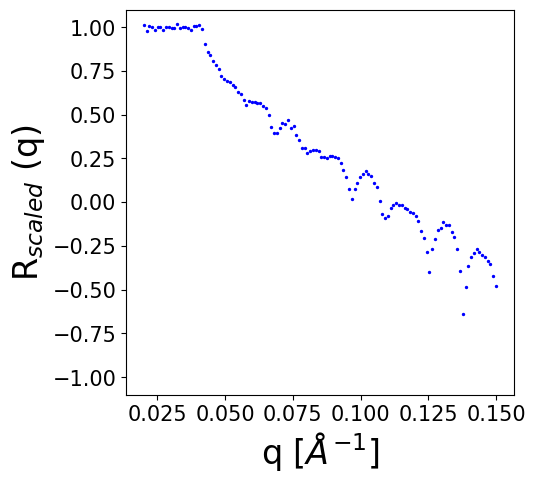

In [13]:
plot_refl_curve(i=15)

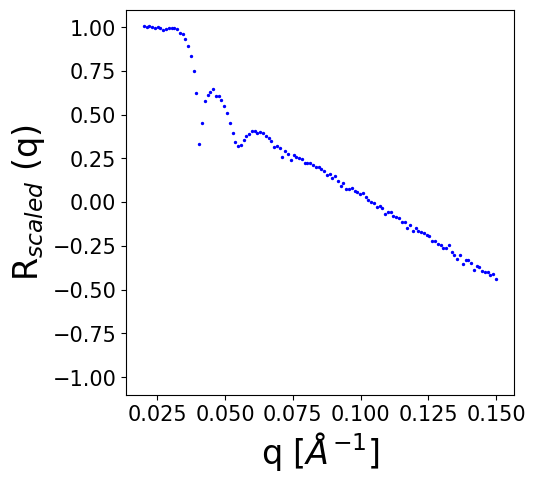

In [14]:
plot_refl_curve(i=30)

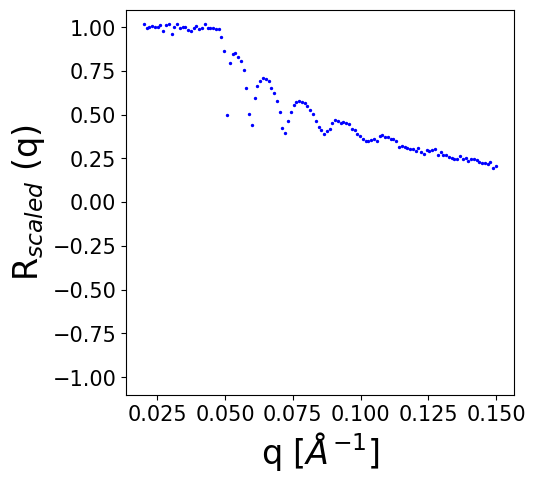

In [15]:
plot_refl_curve(i=45)

# Simplified use of a trained reflectorch model

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact
from reflectorch import EasyInferenceModel, interp_reflectivity

torch.manual_seed(0); # set seed for reproducibility

The `EasyInferenceModel` class simplifies the inference step for single input reflectivity curves. We initialize an instance using the configuration file of a pretrained model.

In [17]:
inference_model = EasyInferenceModel(config_name='mc_25')

Loading model mc_25


TypeError: get_trainer_by_name() got an unexpected keyword argument 'inference_device'

We consider the following reflectivity curve (for real experimental data it must be first preprocessed and normalized by standard procedures):

In [ ]:
loaded_data_dict = torch.load('../exp_data/data_PTCDI-C3.pt')
curve_exp = loaded_data_dict['curves'][0]
q_exp = loaded_data_dict['q'][0]

print(curve_exp.shape, q_exp.shape, q_exp.min(), q_exp.max())

We interpolate the reflectivity curve to the q points the model was trained on:

In [ ]:
q_model = inference_model.trainer.loader.q_generator.q.cpu().numpy()
exp_curve_interp = interp_reflectivity(q_model, q_exp, curve_exp)

We specify the prior bounds for the parameters as a list of tuples `(min_prior_bound, max_prior_bound)`.

In [ ]:
prior_bounds = [(0., 400.), (0., 10.), #layer thicknesses (top to bottom)
                (0., 30.), (0., 15.), (0., 15.), #interlayer roughnesses (top to bottom)
                (10., 13.), (20.,21.), (20., 21.)] #real layer slds (top to bottom)

We can invoke the `predict` method of the inference model to obtain the neural network predictions:

In [ ]:
predicted_params = inference_model.predict(exp_curve_interp, q_model, prior_bounds)
pred_curve = predicted_params.reflectivity(inference_model.trainer.loader.q_generator.q).squeeze().cpu().numpy()

[261.91821001 311.47147564  21.61200643  15.18360972  22.33419299
 -17.03783431  -1.59246207  11.33759486]


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_yscale('log')
ax.set_ylim(0.5e-10, 5)
ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax.set_ylabel('R(q)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
y_tick_locations = [10**(-2*i) for i in range(6)]
ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
    
ax.scatter(q_model, exp_curve_interp, c='g', s=2, label='interp exp. curve')
ax.plot(q_model, pred_curve, c='r', label='pred. curve')

ax.legend(loc='upper right', fontsize=14)

Alternatively, by invoking the method `predict_using_widget` (in a Jupyter Notebook), one can make use of an interactive widget for selecting the minimum and maximum prior bound for each parameter:

In [ ]:
predicted_params = inference_model.predict_using_widget(reflectivity_curve, q_values)

Parameter ranges: {'thicknesses': [0.0, 500.0], 'roughnesses': [0.0, 60.0], 'slds': [-25.0, 25.0]}
Allowed widths of the prior bound intervals (max-min): {'thicknesses': [0.01, 500.0], 'roughnesses': [0.01, 60.0], 'slds': [0.01, 4.0]}
Please fill in the values of the minimum and maximum prior bound for each parameter and press the button!


Button(description='Make prediction', style=ButtonStyle())

In [ ]:
predicted_params = inference_model.predict(exp_curve_interp, q_model, prior_bounds)
pred_curve = predicted_params.reflectivity(inference_model.trainer.loader.q_generator.q).squeeze().cpu().numpy()